# Variational Autoencoder

Cette classe d'algorithmes fait appel à des notions de probabilités et d'inférence bayésienne avancées. Un effort a été fait pour simplifier ces notions et favoriser l'aspect pratique. Je conseille néanmoins la lecture de ce [cours](https://www.ceremade.dauphine.fr/~xian/mr081.pdf) très complet pour se familiariser avec le vocabulaire bayésien et pour les anglophones le chapitre "Probability and Information Theory" du [Deep Learning Book](http://www.deeplearningbook.org/contents/prob.html) (qui est trouvable en ligne gratuitement et est en quelque sorte la Bible du Deep Learning).

Pour toute question, me contacter ou ouvrir une issue à laquelle je répondrai dans les plus brefs délais.

## Chargement des données MNIST

In [1]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./mnist/", one_hot=True)

# Load data
x_train = mnist.train.images
y_train = mnist.train.labels
x_test = mnist.test.images
y_test = mnist.test.labels

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_test: ", x_test.shape)
print("y_test: ", y_test.shape)

W1108 17:07:27.812216 4537341376 deprecation.py:323] From <ipython-input-1-9c48f15a73a7>:2: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W1108 17:07:27.813454 4537341376 deprecation.py:323] From /anaconda3/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W1108 17:07:27.814388 4537341376 deprecation.py:323] From /anaconda3/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:262: extract_images (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:

Extracting ./mnist/train-images-idx3-ubyte.gz


W1108 17:07:28.026752 4537341376 deprecation.py:323] From /anaconda3/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.
W1108 17:07:28.028398 4537341376 deprecation.py:323] From /anaconda3/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:110: dense_to_one_hot (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.one_hot on tensors.
W1108 17:07:28.069115 4537341376 deprecation.py:323] From /anaconda3/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future v

Extracting ./mnist/train-labels-idx1-ubyte.gz
Extracting ./mnist/t10k-images-idx3-ubyte.gz
Extracting ./mnist/t10k-labels-idx1-ubyte.gz
x_train:  (55000, 784)
y_train:  (55000, 10)
x_test:  (10000, 784)
y_test:  (10000, 10)


* Visualisation des données

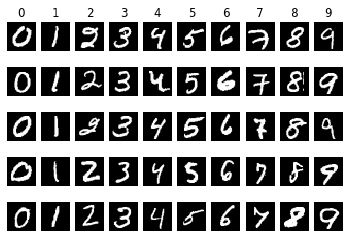

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def plot_mnist(data, classes):
    
    for i in range(10):
        idxs = (classes == i)
        
        # get 10 images for class i
        images = data[idxs][0:10]
            
        for j in range(5):   
            plt.subplot(5, 10, i + j*10 + 1)
            plt.imshow(images[j].reshape(28, 28), cmap='gray')
            # print a title only once for each class
            if j == 0:
                plt.title(i)
            plt.axis('off')
    plt.show()

classes = np.argmax(y_train, 1)
plot_mnist(x_train, classes)

## Application de l'algorithme 

On utilise Tensorflow pour construire et entraîner notre variational autoencoder. 
* D'abord, on construit le graphe de notre réseau de neurones. Celui-ci aura l'architecture suivante :

Entrée de 784 cellules (nombre de pixels d'une image)

Encoder : Deux couches cachées composées respectivement 512 et 256 neurones

Vecteur latent : Par contraste avec un autoencoder classique, le vecteur latent est ici composé de deux vecteurs de deux neurones. En effet, nous avons ici un double objectif : encoder correctement les données dans une dimension plus faible et générer de noouveaux exemples à partir de valeurs aléatoires (ou bruit). Le choix ici est d'utiliser une distribution Gaussienne pour générer des images réalistes par rapport aux données d'entrées. La dimension de l'espace latent sera donc composé d'un vecteur d'écart type et d'un vecteur de moyennes.

Decoder : Deux couches cachées composées respectivement 512 et 256 neurones

Sortie de 784 cellules (nombre de pixels d'une image)


__Fonctionnement :__

Rappel sur les structures neuronales : Le réseau est composé de plusieur couches de neurones. Les neurones de chaque couche sont connectés à chaque neurones de la couche suivante (resp. précédente) par des poids (notés w). Le rôle d'un neurone est d'appliquer une fonction non-linéaire (ici l'opérateur tanh et sigmoid pour la dernière couche du décodeur) à son entrée, qui est une somme des sorties des neurones de la couche précédente pondérée par chaque poids w à laquelle on ajoute une constante propre à chaque neurone appellée biais. 

Bien que portant le nom d'autoencoder, les VAE difèrent nettement des autoencoders classiques (e-g. les Denoising autoencoders) car ils projettent maintenant les données dans un espace latent __continu__ : le vecteur latent ne modélise plus seulement les données d'entrées mais aussi les variations possibles entre celles-ci (dans le cas présent les angles de vues des images, les formes intrinsèques de classes modélisées, les contrastes) en préservant les interractions statistiques entre les variables. 

Plus concrètement, voici à quoi ressemble l'espace latent appris par un autoencoder classique sur les données de MNIST :

![discrete latent space](https://miro.medium.com/max/1442/1*-i8cp3ry4XS-05OWPAJLPg.png)

Les différents clusters (nombres de 0 à 9) sont bien distinct, tout vecteur latent ne tombant pas dans un des cluster générera une sortie irréaliste. A contrario, l'espace latent continu d'un VAE capturera / démêlera les facteurs de variations entre les clusters :

![continuous latent space](https://miro.medium.com/max/1286/1*BIDBG8MQ9-Kc-knUUrkT3A.png)
(Source : [Medium](https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf))


En termes probabilistes, nous cherchons à modéliser la distribution de probabilité des données d'entrées : 

$$P(X) = \int P(X \vert z) P(z) dz$$

Malheureusement, ce calcul n'est pas réalisable (nous ne connaissons aucune des intégrandes car il serait trop coûteux de sommer toutes les valeurs possibles de z). C'est pourquoi $P(z)$ sera inférée à l'aide de la distribution postérieure $P(z \vert X)$ par une méthode bayésienne appelée [inférence variationnelle](https://arxiv.org/abs/1601.00670).

Le principe est le suivant :

- Nous approximons $P(z \vert X)$ à l'aide d'une distribution plus simple (ici Gaussienne) $Q_\phi(\mathbf{z}\vert\mathbf{X})$ telle que : $% <![CDATA[
\begin{aligned}
\mathbf{z} &\sim Q_\phi(\mathbf{z}\vert\mathbf{X}^{(i)}) = \mathcal{N}(\mathbf{z}; \boldsymbol{\mu}^{(i)}, \boldsymbol{\sigma}^{2(i)}\boldsymbol{I})
\end{aligned} %]]>$


- Pour rendre $Q_\phi(\mathbf{z}\vert\mathbf{X})$ la plus proche possible de $P_\theta(\mathbf{z}\vert\mathbf{X})$, nous minimison la [KL-Divergence](https://fr.wikipedia.org/wiki/Divergence_de_Kullback-Leibler) entre ces deux distributions définie par :

$$% <![CDATA[
\begin{aligned}
& D_\text{KL}( q_\phi(\mathbf{z}\vert\mathbf{x}) \| p_\theta(\mathbf{z}\vert\mathbf{x}) ) & \\
&=\int q_\phi(\mathbf{z} \vert \mathbf{x}) \log\frac{q_\phi(\mathbf{z} \vert \mathbf{x})}{p_\theta(\mathbf{z} \vert \mathbf{x})} d\mathbf{z} &
\end{aligned} %]]>$$


En appliquant le théorême de Bayes et en réarrangeant cette équation, nous pouvons réécrire :

$$\log P_\theta(\mathbf{X}) - D_\text{KL}( Q_\phi(\mathbf{z}\vert\mathbf{X}) \| P_\theta(\mathbf{z}\vert\mathbf{X}) ) = \mathbb{E}_{\mathbf{z}\sim Q_\phi(\mathbf{z}\vert\mathbf{X})}\log p_\theta(\mathbf{X}\vert\mathbf{z}) - D_\text{KL}(Q_\phi(\mathbf{z}\vert\mathbf{X}) \| p_\theta(\mathbf{z}))$$


Le premier terme à gauche est appelé log-vraisemblance, maximiser ce terme par rapport à ses paramètres (ici vecteurs de moyennes et écarts-types) revient à maximiser la probabilité de générer des données proches des données d'entrée. 
Le deuxième terme à gauche peut être considéré comme un terme d'erreur assurant que la distribution plus simple $Q$ produise des vecteurs latents générant des $X$ proche des données d'entrée.

Malheureusement, nous ne pouvons pas maximiser l'expression de gauche car nous ne connaissons ni la vraisemblance ni la distribution postérieure $D_\text{KL}( P_\phi(\mathbf{z}\vert\mathbf{X})$. C'est pourquoi nous utiliserons l'expression de droite comme fonction perte à minimiser par notre réseau de neurones :

$$% <![CDATA[
\begin{aligned}
L_\text{VAE}(\theta, \phi)
&= - \mathbb{E}_{\mathbf{z} \sim Q_\phi(\mathbf{z}\vert\mathbf{X})} \log p_\theta(\mathbf{X}\vert\mathbf{z}) + D_\text{KL}( Q_\phi(\mathbf{z}\vert\mathbf{X}) \| P_\theta(\mathbf{z}))
\end{aligned} %]]>$$


Nous verrons dans la partie "Fonction de perte à minimiser" comment exprimer cette fonction sous hypothèse gaussienne et la minimiser à l'aide d'une descente de gradient stochastique.

![Variational autoencoder archi](https://lilianweng.github.io/lil-log/assets/images/vae-gaussian.png)


### Paramètres du modèle

In [3]:
# Nombre de cellules en entrée (nombre de pixels d'une image): 
number_inputs = 28 * 28

# Nombre de neurones sur la première couche de l'encodeur et dernière couche du décodeur
number_neurons_hidden_1 = 512 

# Nombre de neurones sur la deuxième couche de l'encodeur et deuxième couche du décodeur
number_neurons_hidden_2 = 256

# Nombre de neurones sur la troisième couche de l'encodeur et première couche du décodeur
number_neurons_hidden_3 = 128

# Dimension latente
latent_dim = 2

# Taux d'apprentissage de la descente de gradient
learning_rate = 0.00007

# Nombre d'itérations à l'entraînement
number_training_epochs = 30

# Taille du batch : Nombre d'images à coonsidérer pour chaque itération
train_batch_size = 128

import tensorflow as tf

def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))

# Création des poids et biais à l'aide de variables Tensorflow
weights = {
'encoder_weights_1': tf.Variable(glorot_init([number_inputs, number_neurons_hidden_1])),
'encoder_weights_2': tf.Variable(glorot_init([number_neurons_hidden_1, number_neurons_hidden_2])),
'encoder_weights_3': tf.Variable(glorot_init([number_neurons_hidden_2, number_neurons_hidden_3])),
'z_mean': tf.Variable(glorot_init([number_neurons_hidden_3, latent_dim])),
'z_std': tf.Variable(glorot_init([number_neurons_hidden_3, latent_dim])),
'decoder_weights_1': tf.Variable(glorot_init([latent_dim, number_neurons_hidden_1])),
'decoder_weights_2': tf.Variable(glorot_init([number_neurons_hidden_1, number_neurons_hidden_2])),
'decoder_weights_3': tf.Variable(glorot_init([number_neurons_hidden_2, number_neurons_hidden_3])),
'decoder_weights_out': tf.Variable(glorot_init([number_neurons_hidden_3, number_inputs]))
}
                                            
biases = {
'encoder_biases_1': tf.Variable(glorot_init([number_neurons_hidden_1])),
'encoder_biases_2': tf.Variable(glorot_init([number_neurons_hidden_2])),
'encoder_biases_3': tf.Variable(glorot_init([number_neurons_hidden_3])),
'z_mean': tf.Variable(glorot_init([latent_dim])),
'z_std': tf.Variable(glorot_init([latent_dim])),
'decoder_biases_1': tf.Variable(glorot_init([number_neurons_hidden_1])),
'decoder_biases_2': tf.Variable(glorot_init([number_neurons_hidden_2])),
'decoder_biases_3': tf.Variable(glorot_init([number_neurons_hidden_3])),
'decoder_biases_out': tf.Variable(glorot_init([number_inputs]))
}

### Création de l'autoencoder par couches

* Encoder

In [4]:
def create_encoder(encoder_inputs):
    encoder_layer_1 = tf.nn.tanh(tf.add(tf.matmul(encoder_inputs, weights['encoder_weights_1']),
                                        biases['encoder_biases_1']))

    encoder_layer_2 = tf.nn.tanh(tf.add(tf.matmul(encoder_layer_1, weights['encoder_weights_2']),
                                        biases['encoder_biases_2']))
    
    encoder_layer_3 = tf.nn.tanh(tf.add(tf.matmul(encoder_layer_2, weights['encoder_weights_3']),
                                        biases['encoder_biases_3']))
    
    mu = tf.matmul(encoder_layer_3, weights['z_mean']) + biases['z_mean']
    log_sigma = tf.matmul(encoder_layer_3, weights['z_std']) + biases['z_std']

    
    return mu, log_sigma

* Decoder

In [5]:
def create_decoder(decoder_inputs):
    decoder_layer_1 = tf.nn.tanh(tf.add(tf.matmul(decoder_inputs, weights['decoder_weights_1']),
                                   biases['decoder_biases_1']))

    decoder_layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(decoder_layer_1, weights['decoder_weights_2']),
                                   biases['decoder_biases_2']))
    
    decoder_layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(decoder_layer_2, weights['decoder_weights_3']),
                                   biases['decoder_biases_3']))
    
    decoder_layer_out = tf.nn.sigmoid(tf.add(tf.matmul(decoder_layer_3, weights['decoder_weights_out']),
                                   biases['decoder_biases_out']))
    
    return decoder_layer_out

* Autoencoder complet

In [6]:
vae_inputs = tf.placeholder("float", [None, number_inputs])

mu, log_sigma = create_encoder(vae_inputs)

eps = tf.random_normal(tf.shape(log_sigma), dtype=tf.float32, mean=0., stddev=1.0,
                       name='epsilon')

z = mu + tf.exp(log_sigma / 2) * eps

decoder_model = create_decoder(z)

y_prediction = decoder_model

y_true = vae_inputs 

### Fonction de perte à minimiser

La fonction de perte utilisée pour les variational autoencoder est appellée ELBO (Evidence Lower Bound) car elle représente la borne inférieure de l'évidence $p(x)$. Elle se distingue de celle des autoencoders classiques dans la mesure ou elle tient compte de deux termes d'erreur : 

* L'erreur de reconstruction : elle mesure l'écart entre l'image d'entrée et celle générée en sortie de décodeur
* La KL-Divergence entre entre la distribution postérieure variationnelle la probabilité marginale des vecteurs latents

Nous avons vu que cette fonction s'exprimait :

$$% <![CDATA[
\begin{aligned}
L_\text{VAE}(\theta)
&= - \mathbb{E}_{\mathbf{z} \sim Q_\phi(\mathbf{z}\vert\mathbf{X})} \log p_\theta(\mathbf{X}\vert\mathbf{z}) + D_\text{KL}( Q_\phi(\mathbf{z}\vert\mathbf{X}) \| P_\theta(\mathbf{z}))
\end{aligned} %]]>$$

* L'erreur de reconstruction (premier terme) se minimise à l'aide de l'entropie croisée binaire :

$$% <![CDATA[
\begin{aligned}
L_\text{reconstruction}(\theta)
&= - \mathbb{E}_{\mathbf{z} \sim Q_\phi(\mathbf{z}\vert\mathbf{X})} \log p_\theta(\mathbf{X}\vert\mathbf{z}) & \\
&= - \sum_{i=1}^n {X^{(i)}\log(X_\text{decoder}^{(i)}) + (1 - X^{(i)})\log(1 - X_\text{decoder}^{(i)})}
\end{aligned} %]]>$$

Où $X^{(i)}$ est la i-ème image réelle (son vecteur de pixels) et $X_\text{decoder}^{(i)}$ sa reconstruction en sortie de décoder. Plusieurs types de fonctions de pertes existent et peuvent être performantes selon le besoin. 

* La KL-Divergence, de son côté est plus difficile à obtenir car elle néecessite le calcul d'intégrales sur des fonctions gaussiennes. Or, une solution de forme fermée existe et est décrite dans le papier original de [Kingma et al.](https://arxiv.org/pdf/1312.6114.pdf). Elle s'exprime ainsi :

$${-\mathcal{D}}_{KL}(Q_\phi(z|X) || P_\theta(z)) = -\frac{1} 2 \sum{(1 + log(\sigma^2) - \mu^2 - \sigma^2)}$$

(Démonstration dans la partie "Annexe")

Pour simplifier l'entraînement, nous considérons que l'encoder ne calcule pas $\sigma$ mais $log(\sigma)$, c'est pourquoi nous appliquons l'opérateur exponentiel pour obtenir la valeur de $\sigma$.

Nous désignons ensuite la fonction de perte comme la mooyenne de ces deux fonctions

In [7]:
def reconstruction_loss(x_reconstructed, x_true):
    # Perte de reconstruction, le terme 1e-10 dans la fonction tf.log permet d'éviter de calculer le log de 0.
    encode_decode_loss = x_true * tf.log(1e-10 + x_reconstructed) \
                         + (1 - x_true) * tf.log(1e-10 + 1 - x_reconstructed)
    encode_decode_loss = -tf.reduce_sum(encode_decode_loss, 1)
    
    return encode_decode_loss
    
def kullback_leibler_divergence(mu, log_sigma):    # KL Divergence loss

    kl_div_loss = 1 + log_sigma - tf.square(mu) - tf.exp(log_sigma)
    kl_div_loss = -0.5 * tf.reduce_sum(kl_div_loss, 1)    
    return -0.5 * tf.reduce_sum(1 + 2 * log_sigma - mu**2 -
                                        tf.exp(2 * log_sigma), 1)
                       
vae_loss = tf.reduce_mean(reconstruction_loss(y_prediction, y_true) + kullback_leibler_divergence(mu, log_sigma))

#loss_function = vae_loss(decoder_model, vae_inputs)

* Puis, nous utiliserons l'algorithme [RMSProp](https://towardsdatascience.com/understanding-rmsprop-faster-neural-network-learning-62e116fcf29a) pour minimiser cette fonction.

In [8]:
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(vae_loss)

W1108 17:07:29.751254 4537341376 deprecation.py:323] From /anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1108 17:07:29.883757 4537341376 deprecation.py:506] From /anaconda3/lib/python3.7/site-packages/tensorflow/python/training/rmsprop.py:119: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


* Sauvegarde du modèle pour réutilisation future

In [9]:
import os

model_dir = 'Models_directory'
autoencoder_file = 'VAE.ckpt'
autoencoder_model = os.path.join(model_dir, autoencoder_file)
saver = tf.train.Saver()

### Entraînement

On lance maintenant la boucle d'entraînement afin d'initialiser les valeurs de chaque variable tensorflow (ou tenseurs) définies précédemment et de lancer l'entraînement.

L'ensemble des tenseurs et opérations définis plus haut forme un Graph, l'étape d'initialisation consiste tout simplement à assigner des valeurs réelles (les données ainsi que les poids / biais aléatoirement initialisés) aux valeurs symboliques (tenseurs) et lancer les opérations sur celles-ci.

Ici, les opérations sont :

* Création des mini-batch de données par échantillonnage pour chaque itération
* Pour chaque epoch : tentative de reconstruction de l'image par encodage et décodagee, calcul de l'erreur de reconstruction / KL-Divergence et de son [gradient](https://fr.wikipedia.org/wiki/R%C3%A9tropropagation_du_gradient) par rapport aux poids et biais (forward pass) puis mise à jour des poids et biais en soustrayant une partie de ce gradient à chaque poids / biais (backward pass).

In [10]:
var_initializer = tf.global_variables_initializer()

with tf.Session() as session:
    session.run(var_initializer)
    number_batches = int(x_train.shape[0]/train_batch_size)
    # Training cycle
    for epoch in range(number_training_epochs):
        # Iterations over all transaction batches
        for i in range(number_batches):
            # Random selection of transactions in train subset to build the mini-batch
            index_batch = np.random.choice(x_train.shape[0], train_batch_size)
            batch_transactions = x_train[index_batch]
            # Run of the model, which performs:
            #       - loss calculation
            #       - optimization of weights and biases values, by using gradient descent
            optimization, loss = session.run(
                [train, vae_loss], feed_dict={vae_inputs: batch_transactions})

        print("Epoch:", '%02d' % (epoch + 1), " -  loss = ", "{:.4f}".format(loss))
    
    model_path = saver.save(session, autoencoder_model)
    print("Modèle sauvegardé dans le fichier : {}".format(model_path))

    print("Fin de l'entraînement, bon autoencodage ! \n")

Epoch: 01  -  loss =  232.9648
Epoch: 02  -  loss =  202.4954
Epoch: 03  -  loss =  196.2549
Epoch: 04  -  loss =  193.1108
Epoch: 05  -  loss =  184.7171
Epoch: 06  -  loss =  187.2911
Epoch: 07  -  loss =  184.0617
Epoch: 08  -  loss =  176.4549
Epoch: 09  -  loss =  181.6848
Epoch: 10  -  loss =  179.1732
Epoch: 11  -  loss =  174.1978
Epoch: 12  -  loss =  173.6547
Epoch: 13  -  loss =  172.5066
Epoch: 14  -  loss =  168.4610
Epoch: 15  -  loss =  171.9714
Epoch: 16  -  loss =  178.2183
Epoch: 17  -  loss =  174.7566
Epoch: 18  -  loss =  176.5271
Epoch: 19  -  loss =  164.7077
Epoch: 20  -  loss =  163.3408
Epoch: 21  -  loss =  164.3710
Epoch: 22  -  loss =  168.9598
Epoch: 23  -  loss =  167.7850
Epoch: 24  -  loss =  162.5034
Epoch: 25  -  loss =  168.4838
Epoch: 26  -  loss =  168.8366
Epoch: 27  -  loss =  165.8277
Epoch: 28  -  loss =  161.1838
Epoch: 29  -  loss =  152.7943
Epoch: 30  -  loss =  158.8061
Modèle sauvegardé dans le fichier : Models_directory/VAE.ckpt
Fin de l

A tester : Visualisation de l'espace latent (sortie de la dernière couche de l'encoder) et des images encodées. Ré-entrainement de l'autoencoder avec un espace latent de deux ou trois dimensions et visualisation par label afin de comparer les résultat avec une ACP.

W1108 17:13:53.819193 4537341376 deprecation.py:323] From /anaconda3/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


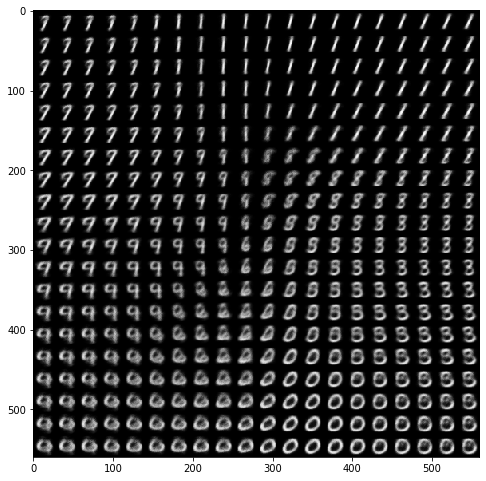

In [11]:
# Testing
# Autoencoder model obtained during training phase is retrieved
autoencoder_model = os.path.join(model_dir, autoencoder_file)
saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, autoencoder_model)

    noise_input = tf.placeholder(tf.float32, shape=[None, latent_dim])

    decoder = create_decoder(noise_input)
    # Building a manifold of generated digits
    n = 20
    x_axis = np.linspace(-3, 3, n)
    y_axis = np.linspace(-3, 3, n)

    canvas = np.empty((28 * n, 28 * n))
    for i, yi in enumerate(x_axis):
        for j, xi in enumerate(y_axis):
            z_mu = np.array([[xi, yi]] * train_batch_size)
            x_mean = sess.run(decoder, feed_dict={noise_input: z_mu})
            canvas[(n - i - 1) * 28:(n - i) * 28, j * 28:(j + 1) * 28] = \
            x_mean[0].reshape(28, 28)

    plt.figure(figsize=(8, 10))
    Xi, Yi = np.meshgrid(x_axis, y_axis)
    plt.imshow(canvas, origin="upper", cmap="gray")
    plt.show()

A tester : Comparer les résultat avec une ACP. Entraîner l'algorithme sur une autre source de données

## Annexe

Nous modélisons ces distributions à l'aide d'une loi Normale, soit : 
$$q(z|x)=\mathcal{N}(z;\mu,\Sigma)$$
$$p(z)=\mathcal{N}(0,I)$$

Où :

- $I$ désigne la matrice identité (matrice nulle avec des 1 sur la diagonale)

- $\mu$ désigne le vecteur de moyenne en sortie d'encoder

- $\Sigma$ désigne le vecteur d'écart-type en sortie d'encoder

Nous pouvons calculer la KL-Divergence ainsi :

$$\begin{align}
D_\text{KL}( Q_\phi(\mathbf{z}\vert\mathbf{X}) \| P_\theta(\mathbf{z}))
&=
\int \left[\log( p(x)) - log( q(x)) \right] p(x) dx\\
&=
\frac{1}{2}\left[\log\frac{|\Sigma_2|}{|\Sigma_1|} - n + \text{tr} \{ \Sigma_2^{-1}\Sigma_1 \} + (\mu_2 - \mu_1)^T \Sigma_2^{-1}(\mu_2 - \mu_1)\right]\\
&= \frac{1}{2}\left[\log\frac{|I|}{|\Sigma|} - n + \text{tr} \{ I^{-1}\Sigma \} + (\vec{0} - \mu)^T I^{-1}(\vec{0} - \mu)\right]\\
&= \frac{1}{2}\left[-\log{|\Sigma|} - n + \text{tr} \{ \Sigma \} + \mu^T \mu\right]\\
&= \frac{1}{2}\left[-\log\prod_i\sigma_i^2 - n + \sum_i\sigma_i^2 + \sum_i\mu^2_i\right]\\
&= \frac{1}{2}\left[-\sum_i\log\sigma_i^2 - n + \sum_i\sigma_i^2 + \sum_i\mu^2_i\right]\\
&= \frac{1}{2}\left[-\sum_i\left(\log\sigma_i^2 + 1\right) + \sigma_i^2 + \mu^2_i\right]\\
\end{align}$$
